In [1]:
# Pandas pour manipuler les tableaux de données
import pandas as pd
pd.set_option('display.max_columns', 500)

# Numpy pour les listes de données numériques et les fonctions classiques mathématiques
import numpy as np

# scipy (librairie scientifique) pour les fonctions statistiques et autres utilisaires
import scipy

# scikit learn pour les outils de machine learning
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# librairies pour la visualisation de données
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# et quelques options visuelles
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(15,8)})

In [2]:
# cette fonction évalue la corrélation entre variables qualitatives en 
# - élaboration du tableau de contingence des valeurs
# - calcul du chi2 de cet tableau 
# - calcul du coefficient de cramer qui est une normalisation du coefficient chi2
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [3]:
# élaboration de deux listes de variables aléatoires
x = np.random.randint(0,20, size=1000)
y = np.random.randint(0,20, size=1000)

In [4]:
# test pour deux listes décorrélées
cramers_v(x,y)

0.051338688106378906

In [5]:
# test pour deux listes totalement corrélées
cramers_v(x,x)

1.0

In [6]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [8]:
# les données ont été téléchargées sur kaggle et enregistrées en local 
# dans un répertoire similaire que celui en ligne sur kaggle, ainsi le script
# pourra tourner aussi bien en ligne qu'en local
train = pd.read_csv('train_titanic.csv')
test =  pd.read_csv('test_titanic.csv')
train.head()

FileNotFoundError: [Errno 2] No such file or directory: 'train_titanic.csv'

In [8]:
# affichage des 5 premières lignes du jeu de test
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


On va concaténer les jeux de tests train et test pour pouvoir les transformer et les analyser ensemble, le nouveau jeu de données sera nommé "data", pour cela on crée la colonne "Survived" dans "test" avec la valeur np.nan (not a number ... valeur indéterminée)

In [9]:
test['Survived']=np.nan
data=pd.concat([train,test],keys=['train','test'], join='inner')
data.index=data.index.droplevel(level=1)

Le nouveau jeu de données comportet 1309 lignes.

In [10]:
len(data)

1309

Il est toujours possible de séparer les données d'entrainement et de test :

In [11]:
len(data.loc['test'])

418

## 5.3 Structure des données

In [12]:
# affichage de la liste et format des différentes variables
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, train to test
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 172.9+ KB


### Liste des variables

**Qualitatives:**
- **Nominales** variables qui ont deux valeurs ou plus mais sans ordre défini.
   > - **Cabin** : numéro de cabine : données très incomplètes, il faudra voir si on peut en tirer quelque chose
   > - **Embarked** Port d'embarquement 
            C(Cherbourg)
            Q(Queenstown) 
            S(Southampton)
        
- **Dichotomiques** Variables nominale prenant deux valeurs
   > - **Sex**
            Female
            Male
- **Ordinales**(variables qui ont deux valeurs ou plus avec un ordre bien défini, pour lesquelles on tpeut onc définir un ordre croissant ou dcraoissant.)
   > - **Pclass** la première classe est la plus prestigieuse, suivi des 2e et 3e
            1(Upper)
            2(Middle) 
            3(Lower)
***
**Quantitatives:**
- **Discrétes**
  >  - **Passenger ID** identifiant passager: ne sera pas utilisé pour l'apprentissage, mais doit être conservé pour générer le fichier résultat dans lequel on doit fournir "PassengerId + Survived"
  >  - **SibSp** nombre de frère, soeur, beau-frère, belle soeur, mari ou femme : données numériques et complètes
  >  - **Parch** nombre de parents et d'enfants : données numériques et complètes
  >  - **Survived** 0 : décédé, 1 : a survécu, c'est la cible, fournie uniquement pour le jeu de donnée d'entrainement évidemment

- **Continues**
>  - **Age** en années : données numériques, mais incomplètes (1046/1309)
>  - **Fare** prix du ticket : données numériques et incomplètes (il n'en manque qu'une)
***
**Variable Textuelle**
> - **Ticket** numéro du ticket : données non numériques et complètes
> - **Name** au format "Nom, Titre prenom", par exemple "Allen, Mr. William Henry" 



# 6. Analyse et mise en forme des données

Pour effectuer une analyse statistique il est nécessaire de pré-traiter les données :
- identifier et traiter les valeurs aberrantes
- identifier et traiter valeurs manquantes
- formats : adaptation des données textuelles ou de type objet (données qualitatives)
- si nécessaire, on peut centrer et réduire les données, ou éliminer les assymétries
- supprimer les données jugées inutiles, sans correlation avec la cible

## 6.1 PassengerId

In [13]:
# est-ce qu'il y a des doublons dans les identifiants
data.PassengerId.duplicated().sum()

0

In [14]:
# describe permet d'avoir quelques éléments statistiques sur les données
data.PassengerId.describe()

count    1309.000000
mean      655.000000
std       378.020061
min         1.000000
25%       328.000000
50%       655.000000
75%       982.000000
max      1309.000000
Name: PassengerId, dtype: float64

Il n'y a pas de doublons ni de valeurs aberrantes, les identifiants vont de 1 à 1309, on conserve cette caractéristique telle quelle, elle ne servira pas pour l'apprentissage mais pour identifier de manière unique les passagers

## 6.2. Survived

In [15]:
# liste des valeurs prises par Survived, on utilise value_counts() qui permet de lister les valeurs prise 
# pas une variable donnée ainsi que l'occurence de chaque valeur
data.Survived.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

Les données sont numériques (0 pour les passagers disparus, 1 pour les survivants), c'est la donnée cible, il n'y a pas de valeurs aberrantes. Voici visuellement la répartition des survivants et des victimes :

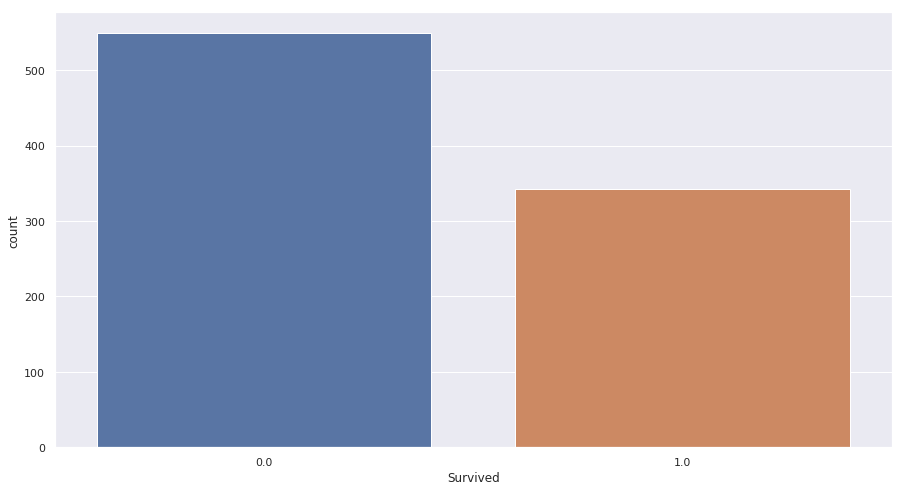

In [16]:
sns.set(rc={'figure.figsize':(15,8)})
_ = sns.countplot(x="Survived", data=data)

Dans le §4 on avait vu que 498 passagers avaient survécu, dans le jeu de test il y en a 342, on devrait donc en trouver 156 dans le jeu de test.

## 6.3 Pclass

Comme à la SNCF, il y a plusieurs classes dans le Titanic, la première classe est la plus prestigieuse.
Voyons quel est le taux de survie par classe, sns.barplot permet de générer un diagramme en barres de y(Survived) en fonction de la valeur x (ici Pclass)

In [17]:
# liste des valeurs prises par Pclass
data.Pclass.value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

Pclass prend 3 valeurs, 1,2 ou 3, il n'y a pas de valeur aberrante ni de valeurs manquantes.

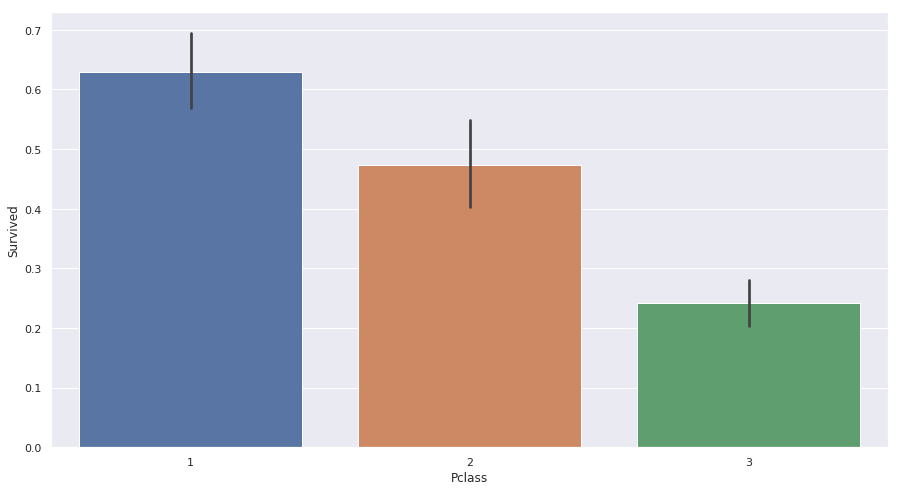

In [18]:
_ = sns.barplot(x="Pclass",y="Survived", data=data)

Visuellement il y a une forte dépendance entre classe et survie, voyons quel est le niveau de corrélation. Beaucoup de participants aux challenges Kaggle font l'erreur, ou du moins l'approximation de calculer la corrélation entre tout type de variables (qualitative ordinale/nominale -- quantitative ...) par le coefficient de pearson, mais ce calcul n'est en réalité valable que pour deux variables quantitatives. Ici on va utiliser le critère de cramer qui calcule un chi2 normalisé :

In [19]:
correlation = {}
correlation['Pclass']=cramers_v(data.loc['train','Pclass'],data.loc['train','Survived'])
print(correlation['Pclass'])

0.33668387622245516


Et voici visuellement sur un tableau croisé comment se répartissent les données :

In [20]:
pd.crosstab(data["Survived"],data["Pclass"])

Pclass,1,2,3
Survived,,,
0.0,80,97,372
1.0,136,87,119


La valeur cible est donc dépendante de la "classe", on conserve donc cette information.

## 6.4. Exploitation du nom

In [21]:
data.Name[0]

'Braund, Mr. Owen Harris'

Le nom (champ Name) est peu exploité dans les kernels publiés sur KAggle, pourtant on peut en tirer au moins 3 informations intéressantes :
- le "Titre" (Mr, Col, ...)
- le Nom de famille qui permettra de créer des groupes (potentiellement regrouper les passagers par famille)
- le Prenom, à priori donnée inutile mais le Prénom est souvent utilisé en Data mining pour essayer d'évaluer l'age de la personne quand cette donnée n'existe pas, en effet les prénoms sont à la mode pendant une certaine période, si on connait le prenom on peut estimer l'age le plus probable en fonction de la période ou le prenom en question était à la mode !! (méthode très approximative mais si on n'a rien d'autre c'est toujours çà)

## Title (titre du type Mr, Miss ...)

In [22]:
data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

Voici les valeurs trouvées et leur occurence :

In [23]:
data.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
Don               1
Jonkheer          1
Mme               1
Dona              1
Capt              1
Lady              1
the Countess      1
Sir               1
Name: Title, dtype: int64

In [24]:
pd.crosstab(data.Title,data.Survived)

Survived,0.0,1.0
Title,,
Capt,1,0
Col,1,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23
Miss,55,127


Il y a beaucoup de titres peu fréquents, on va fusionner les titres pour lesquels on n'a qu'une ou deux valeurs puisque statistiquement on ne pourra rien en tirer

In [25]:
data['Title']=data['Title'].replace(['Major','Don','Jonkheer','Capt','Sir'], 'Mr')
data['Title']=data['Title'].replace(['Mlle'], 'Miss')
data['Title']=data['Title'].replace(['Lady','the Countess','Mme','Ms','Dona'], 'Mrs')
data.Title.value_counts()

Mr        763
Miss      262
Mrs       203
Master     61
Dr          8
Rev         8
Col         4
Name: Title, dtype: int64

In [26]:
# voyons si le titre a une influence sur la survie
pd.crosstab(data['Title'], data['Survived']).apply(lambda r: r/r.sum(), axis=1)

Survived,0.0,1.0
Title,,
Col,0.500000,0.500000
Dr,0.571429,0.428571
Master,0.425000,0.575000
Miss,0.298913,0.701087
Mr,0.841300,0.158700
Mrs,0.201550,0.798450
Rev,1.000000,0.000000


In [27]:
correlation['Title']=cramers_v(data.loc['train']['Title'],data.loc['train']['Survived'])
print(correlation['Title'])

0.5690891244305082


On va pouvoir utiliser cette caractéristique, par exemple les Mr ont une très faible espérance de survie, une fois recoupée avec d'autres variables on devrait pouvoir en tirer quelques conclusions intéressantes, visuellement on peut déjà noter certaines rêgles, qu'on vérifiera à la fin sur notre jeu de test pour voir si la prédiction est correcte :

## Nom de famille

In [28]:
data['Last Name'] = data['Name'].str.split(", ", expand=True)[0]

In [29]:
data['Last Name'].describe()

count     1309
unique     875
top       Sage
freq        11
Name: Last Name, dtype: object

Afin de voir s'il y a une corrélation de la survie entre les membres d'une famille, on va faire le calcul suivant :
    - grouper les données par nom de famille (fonction groupby)
    - pour chaque groupe appliquer une fonction (.agg) qui calculera la variance de la survie ('Survived': 'var')
    - et enfin calculer la moyenne de cette variance

In [30]:
data.loc['train'].groupby('Last Name').agg({'Survived': 'var'}).mean()

Survived    0.16863
dtype: float64

Il y a donc corrélation au sein d'une famille, en effet si le nom de famille n'avait aucune influence, la variance moyenne devrait être de 0.25 environ, pour le prouver nous allons générer un jeu de variables binaires aléatoire et refaire le calcul

In [31]:
data['randNumCol'] = np.random.choice(2,len(data))

In [32]:
data.loc['train'].groupby('Last Name').agg({'randNumCol': 'var'}).mean()

randNumCol    0.239199
dtype: float64

In [33]:
data=data.drop('randNumCol',axis=1)

Et enfin on va créer aussi une valeur numérique pour le nom de famille afin de pouvoir les traiter plus facilement

In [34]:
from sklearn import preprocessing
MyEncoder=preprocessing.LabelEncoder()
MyEncoder.fit(data['Last Name'].sort_values())
data['LastNameNum'] = MyEncoder.transform(data['Last Name'])
data.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Last Name,LastNameNum
train,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,Braund,100


La corrélation peut être calculée par le calcul du coefficient de cramer :

In [35]:
correlation['LastNameNum']=cramers_v(data['LastNameNum'],data['Survived'])
print(correlation['LastNameNum'])

0.2784030688716869


## Prenom

Extraction du prénom, et affectation de ce prénom à une nouvelle colonne "First Name"

In [36]:
data['First Name'] = data['Name'].str.split("\. ", expand=True)[1].str.split(" ", expand=True)[0]

In [37]:
data['First Name'].head()

train       Owen
train       John
train      Laina
train    Jacques
train    William
Name: First Name, dtype: object

On ne va pas en faire grand chose à priori, on conserve le Prenom uniquement s'il fallait identifier une personne en particulier, comme on le verra plus tard pour les domestiques.

## 6.5. Champ "sex"

Sex est un objet, on remplace par une valeur numérique binaire

In [38]:
gender = {'male': 1,'female': 0}
data.Sex = [gender[item] for item in data.Sex]

Calcul de la corrélation :

In [39]:
correlation['Sex']=cramers_v(data.loc['train']['Sex'],data.loc['train']['Survived'])
print(correlation['Sex'])

0.5401999468101071


Là on a une assez forte corrélation, c'est pour l'instant la variable la plus déterminante, s'il fallait par exemple passer par un arbre de décision ce serait surement le premier critère à prendre en compte. Visuellement si on regarde le taux de survie en fonction du Sexe c'est flagrant :

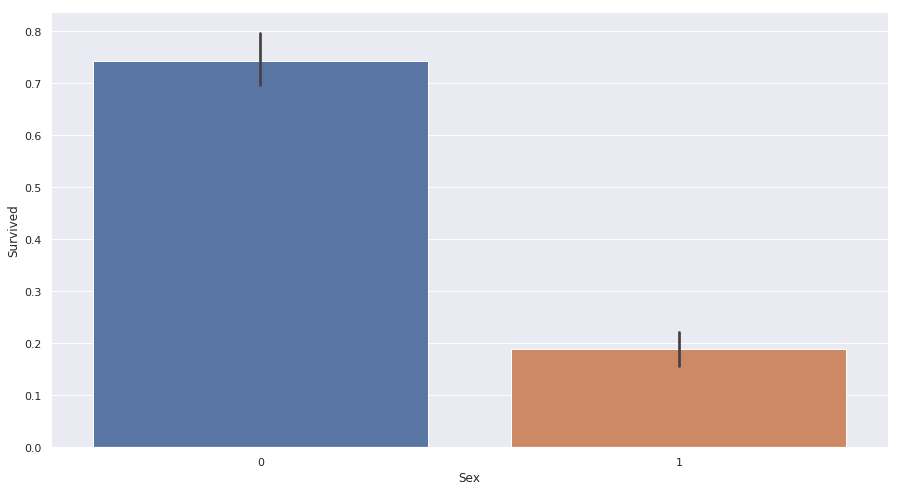

In [40]:
_ = sns.barplot(x="Sex",y="Survived", data=data)

## 6.6. Age

Il manque beaucoup de données, et pas question de supprimer les passagers pour lesquels il manque l'age. On pourrait utiliser les algorithmes classiques d'imputation (sklearn imputers) mais ils sont assez basiques et remplacent les données manquantes par la moyenne ou autre méthode trop approximative, voyons d'abord quelle est l'importance de cette variable et si nécessaire on va estimer les données manquantes.

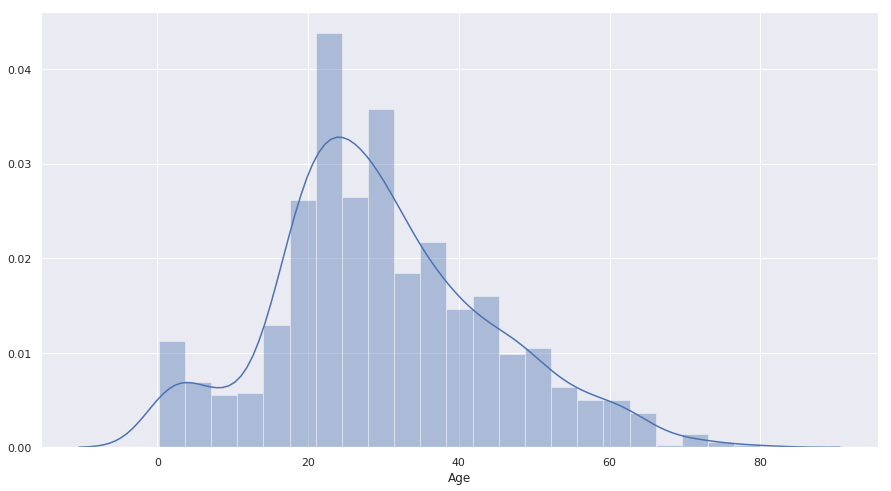

In [41]:
sns.distplot(data.Age.dropna())

In [42]:
data.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

Le test de shapiro va permettre de vérifier si la répartition des ages est une répartition normale :

In [43]:
scipy.stats.shapiro(data.Age.dropna())

(0.9795474410057068, 5.7477918258275196e-11)

La p-value (2e argument retourné) est largement inférieure à 0.05, on peut considérer la répartition comme normale, la variable pourrait être utilisée telle quelle, en la réduisant au besoin, voyons le niveau de corrélation entre age et survie

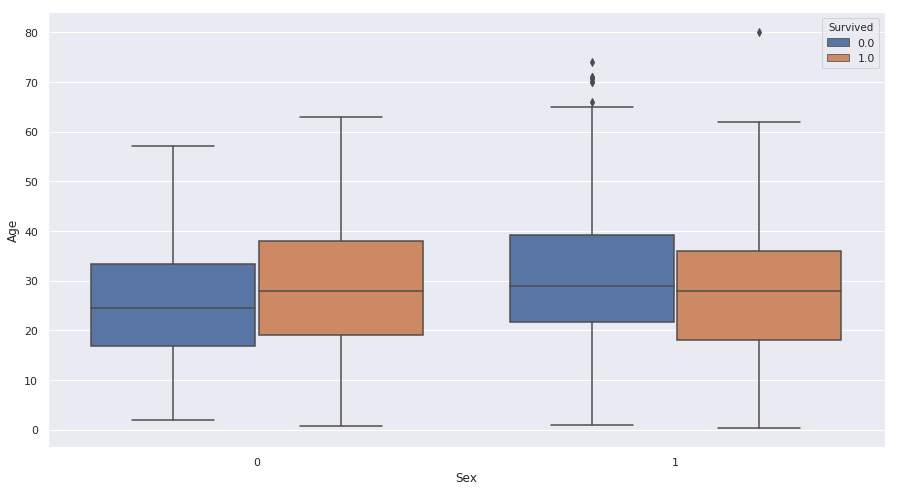

In [44]:
sns.boxplot(x="Sex", y="Age",hue="Survived", data=data)

La corrélation n'est pas flagrante

[Text(0, 0, 'Femme'), Text(0, 0, 'Homme')]

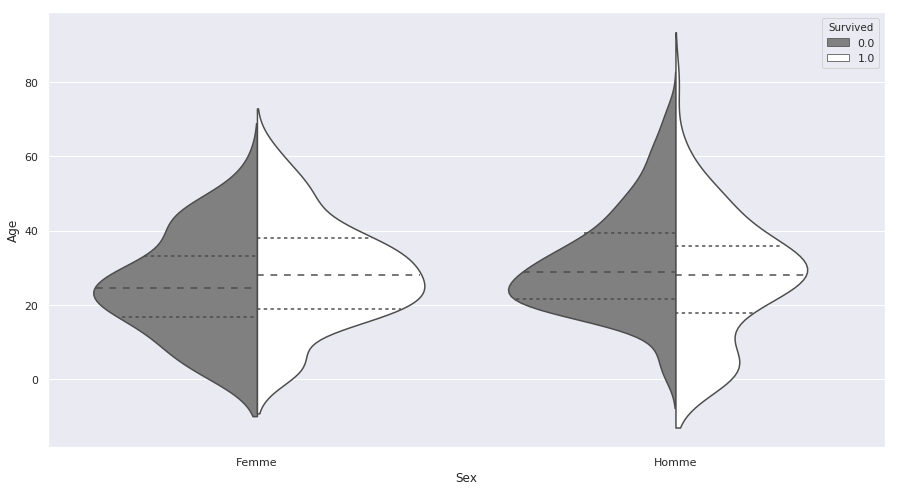

In [45]:
# voyons en détail la répartition des survivants par sexe et par age
sns.set(style="darkgrid", palette="pastel", color_codes=True)
ax = sns.violinplot(x="Sex", y="Age", hue="Survived",
               palette={0.0: "grey", 1.0: "white"},
               split=True, inner="quart",
               data=data)
ax.set_xticklabels(['Femme','Homme'])

on constate une bosse en bas de graphique, entre 0 et 10 ans, les enfants de sexe masculin ont un meilleur taux de survie, voyons la corrélation. Pour mesurer la corrélation on va comparer l'age de la population ayant survécu et l'age de la population ayant succombé au nauffrage, et pour comparer ces deux populations on va utiliser la quantité ETA² pour calculer le degré de correlation :

In [46]:
dataTemp = data.loc['train'].dropna(subset=['Age'])

correlation['Age']=eta_squared(dataTemp.Age,dataTemp.Survived)
print(correlation['Age'])

0.1458768205728677


## 6.6.1 Estimation de l'age pour les données manquantes

Le premier problème à traiter ce sont les données manquantes, on va chercher à remplir ces données, il y a plusieurs possibilités : 
- remplacer les données vides par la moyenne
- supprimer les lignes comportant des données manquantes

Mais ces méthodes ne sont pas optimales, on perd de l'information, on va estimer au mieux l'age de ces passagers.

**Hypothèse** : Pour les passagers voyageant seuls on va considérer que ce sont des adultes, et pour identifier les passagers voyageant seul l'indication la plus fiable est de compter pour chaque numéro de ticket, combien de personnes ont ce même numéro, on va ajouter une colonne à notre jeu de données avec cette indication, en groupant les données par ticket, en comptant les effectifs et en extrayant la valeur obtenue dans une nouvelle colonne

In [47]:
data['TicketSibling'] = data.groupby('Ticket')['Ticket'].transform('count')

Et donc si la valeur en question vaut 1 on peut considérer que nous avaons affaire à un Adulte

In [48]:
data.loc[(data.Age.isna())&(data['TicketSibling']==1),'Age']=30

**Hypothèse** : Pour les passagers dont le titre est "Mrs", c'est à dire une femme mariée, on va renseigner la valeur moyenne de l'age des femmes mariées.

In [49]:
data.loc[(data.Age.notna())&(data.Title=="Mrs"),'Age'].mean()

36.65384615384615

In [50]:
data.loc[(data.Age.isna())&(data.Title=="Mrs"),'Age']=37

Pour le reste des passagers "sans Age" j'ai récupéré les données du site internet : https://titanicfacts.net/titanic-passenger-list/ (voir script annexe)

In [51]:
# les données ont été enregistrées dans le fichier age.csv
age = pd.read_csv('../input/titanicdata/age.csv')

FileNotFoundError: File b'../input/titanicdata/age.csv' does not exist

Renseignement de l'information "Age" manquante

In [ ]:
import unicodedata

def text_normalize(text):
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

# on va parcourir la liste des passagers et regarder si les nom de famille correspond, en cas de correspondance unique
# on sait qu'on a trouvé le bon passager et on lui attribue la valeur 1 en colonne Servant
# sinon on croise aussi la donnée prenom pour être sûr

for _,passager in data[data.Age.isna()].iterrows():
    for _,line in age.iterrows():
        x = line['Surname'].split(' ')[0]
        x = text_normalize(x)
        LastName = passager['Last Name']
        FirstName = passager['First Name']
        y = line['First Name'].split(' ')[0]
        y = text_normalize(y)
        if ((x in LastName)&(y in FirstName)):
            data.loc[data.PassengerId==passager.PassengerId,'Age'] = int(line['Age'])

In [ ]:
data.Age.isna().sum()

Pour les 18 passagers qui n'ont toujours pas d'age on va analyser chaque cas à la main en essayant de reconstituer les familles

In [ ]:
data[data.Ticket=='2661']

On a affaire à deux enfants qui voyagent avec leur mère

In [ ]:
# ce sont tous les deux des enfants
data.loc[(data.Age.isna())&(data.Ticket=='2661'),'Age']=10

In [ ]:
data[data.Ticket=='371110']

In [ ]:
# il s'agit de l'épouse de Mr MORAN, on va rire qu'elle a à peu près le même age
data.loc[(data.Age.isna())&(data.Ticket=='371110'),'Age']=25

In [ ]:
data[data.Ticket=='2668']

In [ ]:
# ce sont tous les deux des enfants
data.loc[(data.Age.isna())&(data.Ticket=='2668'),'Age']=10

In [ ]:
data[data.Ticket=='4133']

In [ ]:
# ce sont tous des enfants
data.loc[(data.Age.isna())&(data.Ticket=='4133'),'Age']=10

In [ ]:
data[data.Ticket=='2665']

In [ ]:
# ce sont des enfants, deux soeurs
data.loc[(data.Age.isna())&(data.Ticket=='2665'),'Age']=10

In [ ]:
data[data.Ticket=='367230']

In [ ]:
# ce sont des adultes, deux soeurs
data.loc[(data.Age.isna())&(data.Ticket=='367230'),'Age']=25

In [ ]:
data[data.Ticket=='370365']

In [ ]:
# ce sont des adultes, mari et femme
data.loc[(data.Age.isna())&(data.Ticket=='370365'),'Age']=30

In [ ]:
data[data.Ticket=='2627']

In [ ]:
# on ne peut pas être sur mais on peut imaginer que ce sont deux adultes
data.loc[(data.Age.isna())&(data.Ticket=='2627'),'Age']=18

In [ ]:
data[data.Ticket=='PC 17757']

In [ ]:
# on ne peut pas être sur mais on peut imaginer que c'est un adulte voyageant avec le reste de la famille
data.loc[(data.Age.isna())&(data.Ticket=='PC 17757'),'Age']=25

In [ ]:
data[data.Ticket=='367226']

In [ ]:
# certainement un adulte
data.loc[(data.Age.isna())&(data.Ticket=='367226'),'Age']=25

In [ ]:
data[data.Ticket=='370371']

In [ ]:
# certainement un adulte
data.loc[(data.Age.isna())&(data.Ticket=='370371'),'Age']=20

In [ ]:
data[data.Ticket=='CA. 2343']

In [ ]:
# certainement un enfant
data.loc[(data.Age.isna())&(data.Ticket=='CA. 2343'),'Age']=10

In [ ]:
data[data.Ticket=='A/5. 851']

In [ ]:
# certainement un enfant
data.loc[(data.Age.isna())&(data.Ticket=='A/5. 851'),'Age']=10

In [ ]:
data.Age.isna().sum()

## 6.6.2 identification des adultes et des enfants

Et enfin, comme on l'a vu plus haut, il n'y a pas de forte corrélation entre l'age et la survie, on va simplement distinguer enfants et adultes en créant une nouvelle variable "isParent", ce qui n'est pas chose aisée, on n'est pas adulte à un age bien défini, le but est plutot de distinguer ici :
- les enfants (moins de 14 ans)
- les adultes (plus de 20 ans)
- et entre ces deux, quelqu'un de 18 ans par exemple peut être parent au sens ou il a embarqué avec ses enfants, ou être enfant au sens ou il a embarqué avec ses parents, et comme du coup il peut être parent et enfant il faut créer deux varialbes, isParent, et isEnfant

In [ ]:
data['isParent']=np.nan
data['isEnfant']=np.nan

In [ ]:
data.loc[(data.Parch==0),'isEnfant']=0
data.loc[(data.Parch==0),'isParent']=0

data.loc[(data.Age<14),'isEnfant']=1
data.loc[(data.Age<14),'isParent']=0

data.loc[(data.Parch>0)&(data.Title=='Mrs'),'isEnfant']=0
data.loc[(data.Parch>0)&(data.Title=='Mrs'),'isParent']=1

data.loc[(data.Parch>0)&(data.Title=='Mr'),'isEnfant']=0
data.loc[(data.Parch>0)&(data.Title=='Mr'),'isParent']=1

In [ ]:
for x in data.LastNameNum.unique():
    if len(data[(data.LastNameNum==x)&(data.Title=='Mrs')]):
        data.loc[(data.LastNameNum==x)&(data.Title=='Miss'),'isParent']=0
        data.loc[(data.LastNameNum==x)&(data.Title=='Miss'),'isEnfant']=1
        data.loc[(data.LastNameNum==x)&(data.Title=='Master'),'isParent']=0
        data.loc[(data.LastNameNum==x)&(data.Title=='Master'),'isEnfant']=1
    
    ageMax = data[data.LastNameNum==x].Age.max()
    ageMin = data[data.LastNameNum==x].Age.min()
    data.loc[(data.LastNameNum==x)&(data.Age<(ageMax-18)),'isEnfant']=1
    data.loc[(data.LastNameNum==x)&(data.Age>(ageMin+18)),'isEnfant']=0
    data.loc[(data.LastNameNum==x)&(data.Age<(ageMax-18)),'isParent']=0
    data.loc[(data.LastNameNum==x)&(data.Age>(ageMin+18)),'isParent']=1


In [ ]:
for x in data.Ticket.unique():
    if len(data[(data.Ticket==x)&(data.Title=='Mrs')]):
        data.loc[(data.Ticket==x)&(data.Title=='Miss'),'isParent']=0
        data.loc[(data.Ticket==x)&(data.Title=='Miss'),'isEnfant']=1
        data.loc[(data.Ticket==x)&(data.Title=='Master'),'isParent']=0
        data.loc[(data.Ticket==x)&(data.Title=='Master'),'isEnfant']=1
    
    ageMax = data[data.Ticket==x].Age.max()
    ageMin = data[data.Ticket==x].Age.min()
    data.loc[(data.Ticket==x)&(data.Age<(ageMax-18)),'isEnfant']=1
    data.loc[(data.Ticket==x)&(data.Age>(ageMin+18)),'isEnfant']=0
    data.loc[(data.Ticket==x)&(data.Age<(ageMax-18)),'isParent']=0
    data.loc[(data.Ticket==x)&(data.Age>(ageMin+18)),'isParent']=1


In [ ]:
data.loc[(data.SibSp>1),'isParent']=0
data.loc[(data.SibSp>1),'isEnfant']=1

data.loc[(data.Parch>2),'isParent']=1
data.loc[(data.Parch>2),'isEnfant']=0

In [ ]:
data.isParent.isna().sum()

In [ ]:
data[data.isParent.isna()]

In [ ]:
data.loc[data.PassengerId==137,'isParent']=0
data.loc[data.PassengerId==137,'isEnfant']=1

data.loc[data.PassengerId==418,'isParent']=0
data.loc[data.PassengerId==418,'isEnfant']=1

data.loc[data.PassengerId==540,'isParent']=0
data.loc[data.PassengerId==540,'isEnfant']=1

data.loc[data.PassengerId==1130,'isParent']=0
data.loc[data.PassengerId==1130,'isEnfant']=1

data.loc[data.PassengerId==1041,'isParent']=1
data.loc[data.PassengerId==1041,'isEnfant']=0

In [ ]:
_ = sns.barplot(x="isEnfant",y="Survived", data=data)

Est-ce qu'on a une meilleure corrélation entre cette nouvelle variable et la survie (par rapport à la corrélation Age/Survie)

In [ ]:
correlation['isEnfant']=cramers_v(data.loc['train']['isEnfant'],data.loc['train']['Survived'])
print(correlation['isEnfant'])

On a légèrement amélioré la corrélation mais l'age reste un critère assez peu intéressant. On va créer des classes d'age pour voir si on peut améliorer la situation :

In [ ]:
data['AgeBin']=pd.cut(data['Age'],bins=[0,5,30,65,100],labels=[0,1,2,3],include_lowest=True).astype(int)

In [ ]:
cramers_v(data.loc['train']['AgeBin'],data.loc['train']['Survived'])

In [ ]:
sns.barplot(x="AgeBin",y="Survived", data=data)

On conserve cette nouvelle variable, elle apporte une bonne corrélation avec la survie, il faudra comparer la performance des algorithmes de classification en prenant l'age en tant que donnée quantitative ou l'age transformé en classes d'age.

In [ ]:
correlation['AgeBin']=cramers_v(data.loc['train']['AgeBin'],data.loc['train']['Survived'])
print(correlation['AgeBin'])

Et enfin nous allons centrer et réduire l'age (valeur numérique quantitative initiale) pour améliorer son interprétation par les algorithmes d'apprentissage.

In [ ]:
data['Age']=StandardScaler().fit_transform(data['Age'].values.reshape(-1, 1))

In [ ]:
correlation['Age']=cramers_v(data.loc['train']['Age'],data.loc['train']['Survived'])
print(correlation['Age'])

## 6.7. SibSp

Cette variable représente le nombre de frères+soeurs+épouses, il varie entre 0 et 8

In [ ]:
data.SibSp.describe()

In [ ]:
data.SibSp.value_counts()

In [ ]:
sns.barplot(x="SibSp",y="Survived", data=data)

In [ ]:
correlation['SibSp']=cramers_v(data.loc['train']['SibSp'],data.loc['train']['Survived'])
print(correlation['SibSp'])

On va pour l'instant conserver cette variable telle quelle.

## 6.8. Parch

In [ ]:
data.Parch.value_counts()

In [ ]:
sns.barplot(x="Parch",y="Survived", data=data)

In [ ]:
correlation['Parch']=cramers_v(data.loc['train']['Parch'],data.loc['train']['Survived'])
print(correlation['Parch'])

Là aussi, cette variable semble intéressante, on la conserve telle quelle

## 6.9. Cabine

Informations sur cette variable :

In [ ]:
data[['Cabin','PassengerId']].info()

Il y a beaucoup d'informations manquantes (ou alors beaucoup de passagers n'ayant pas de cabine, ce qui est moins crédible) , on va essayer d'utiliser cette information malgré tout.

On va déjà remplacer les valeurs manquantes par un "X"

In [ ]:
data['Cabin']=data['Cabin'].fillna('X').astype(str).str[0]

Et voyons la corrélation entre type de cabine et taux de survie :

In [ ]:
sns.barplot(x="Cabin",y="Survived", data=data)

In [ ]:
_ = sns.countplot(x="Cabin", data=data)

In [ ]:
correlation['Cabin']=cramers_v(data.loc['train']['Cabin'],data.loc['train']['Survived'])
print(correlation['Cabin'])

Il y a trop peu de données sur la cabine, par ailleurs la classe du passager définit l'emplacement de sa cabine, pour ne pas générer trop de bruit nous allons supprimer cette variable

In [ ]:
data = data.drop(['Cabin'],axis=1)

## 6.10. Ticket

Le numéro de ticket est à priori une donnée aléatoire et peu utile, mais en y regardant de plus près :

In [ ]:
data.Ticket.describe()

Déjà tout le monde a un ticket, toutes les informations sont présentes. Ensuite il y a des "groupes de tickets" c'est à dire des personnes qui ont le même numéro de ticket et qui voyagaient ensemble, ceci peut être une information intéressante, il peut y avoir corrélation dans la destinée des personnes voyageant ensemble, calculons la variance au sein de chaque groupe de billets

In [ ]:
data.groupby('Ticket').agg({'Survived': 'var'}).Survived.value_counts()

In [ ]:
correlation['Ticket']=cramers_v(data.loc['train']['Ticket'],data.loc['train']['Survived'])
print(correlation['Ticket'])

Le résultat est intéressant : pour une majorité des cas il y a forte corrélation entre numéro de billet et survie. 

## 6.11. Port d'embarquement

In [ ]:
data.Embarked.value_counts()

Il n'y a pas de valeurs aberrantes. Par contre il y a deux données manquantes :

In [ ]:
data.Embarked.isna().sum()

In [ ]:
data[data.Embarked.isna()]

Pour les personnes dont on ne sait pas ou elles ont embarqué ... rien de plus facile on va regarder où ont embarqué les autres membres de la famille

In [ ]:
data[data.Ticket==42]

Et bien manque de bol ... ce sont deux femmes voyageant seul et ensemble, et qui ont survécu, elles n'apportent pas grand chose au jeu de données, on va les supprimer

In [ ]:
# pareil pour le port d'embarquement (Embarked), il n'en manque que deux (dans train pas dans test)
# plutot que de faire de fausses hypothèses on supprime les données manquantes
data = data.dropna(subset=['Embarked'])

Voyons si le port d'embarquement joue sur la survie :

In [ ]:
_ = sns.barplot(x="Embarked",y="Survived", data=data)

In [ ]:
_=sns.countplot(x="Embarked", data=data)

In [ ]:
correlation['Embarked']=cramers_v(data.loc['train']['Embarked'],data.loc['train']['Survived'])
print(correlation['Embarked'])

Là aussi on transforme les valeurs de type caractère en valeurs numérique.

In [ ]:
port = {'C': 0,'Q': 1,'S':2}
data.Embarked = [port[item] for item in data.Embarked]

## 6.12. Fare

Fare est le prix payé par la personne.

In [ ]:
data.Fare.describe()

In [ ]:
# nombre de valeurs manquantes
data.Fare.isna().sum()

Voyons quel est le passager en question :

In [ ]:
data[data.Fare.isna()]

Encore quelqu'un voyageant seul on ne peut pas comparer aux autres membres de la famille, on va regarder le cout moyen de la 3e classe :

In [ ]:
data[data.Pclass==3].Fare.describe()

In [ ]:
# on remplace donc la valeur manquante par la moyenne de la 3e classe
data.Fare=data.Fare.fillna(13)

Voyons maintenant la distribution de cette variable :

In [ ]:
_= sns.distplot(data.Fare)

## Valeurs nulles

In [ ]:
(data.Fare==0.0).sum()

Il y a 17 valeurs nulles plus exactement, voyons le profil des passagers en question :

In [ ]:
data[data.Fare==0]

Ce sont tous des hommes voyangeant seul, ayant embarqué au dernier port (2), et ayant pour la grande majorité entre 30 et 40 ans, voyons la répartition des prix pour ces profils, en fonction de la classe : 

In [ ]:
ax = sns.boxplot(x="Pclass", y="Fare", data=data[(data.Title=="Mr")&(data.Embarked==2)&(data.AgeBin==1)&(data.SibSp==0)&(data.Parch==0)])

Il y a très peu de variance pour les profils en question et dans chaque classe, on va donc remplacer (inférer) les prix nuls par les moyennes des profils similaires de chaque classe :

In [ ]:
for classe in data.Pclass.unique():
    PrixMoyen = data[(data.Title=="Mr")&
         (data.Embarked==2)&
         (data.AgeBin==1)&
         (data.SibSp==0)&
         (data.Parch==0)&
         (data.Fare!=0.0)&
         (data.Pclass==classe)].Fare.mean()
    print("Prix moyen de la classe ",classe," = ",PrixMoyen)

In [ ]:
data.loc[(data.Fare==0.0)&
         (data.Pclass==1),'Fare']=37
data.loc[(data.Fare==0.0)&
         (data.Pclass==2),'Fare']=16
data.loc[(data.Fare==0.0)&
         (data.Pclass==3),'Fare']=9

Voyons la forme de la distribution après ces corrections :

In [ ]:
_= sns.distplot(data.Fare)

Et le niveau de corrélation :

In [ ]:
eta_squared(data.loc['train'].Survived,data.loc['train'].Fare)

La corrélation est assez faible, on peut essayer de l'améliorer toutefois. Sur le graphique on voie que qu'il y a une forte assymétrie dans la distribution, on peut d'ailleurs calculer le coefficient d'asymétrie (skewness en anglais) par la fonction "skew" de scipy (qui doit être de zero si la répartition est symétrique ):

In [ ]:
scipy.stats.skew(data.Fare.dropna())

In [ ]:
_= sns.distplot(np.log1p(data.Fare))

Voyons si la corrélation est meilleure avec la donnée Fare dé-symétrisée

In [ ]:
eta_squared(data.loc['train'].Survived,np.log1p(data.loc['train'].Fare))

La corrélation est très faible, mais améliorée, on applique cette transformation

In [ ]:
data.Fare=np.log1p(data.Fare)

Et enfin on va centrer et réduire cette variable :

In [ ]:
data['Fare']=StandardScaler().fit_transform(data['Fare'].values.reshape(-1, 1))

In [ ]:
correlation['Fare']=cramers_v(data.loc['train']['Fare'],data.loc['train']['Survived'])
print(correlation['Fare'])

voyons par ailleurs si on peut l'améliorer en créant des classes de prix. On va utiliser la fonction qcut qui crée des classes à iso-effectifs, plutot que de découper à des valeurs données. 

In [ ]:
data['FareBin']=pd.qcut(data.Fare,5, labels=False)

In [ ]:
sns.barplot(x=data['FareBin'],y=data.Survived)

In [ ]:
correlation['FareBin']=cramers_v(data.loc['train']['FareBin'],data.loc['train']['Survived'])
print(correlation['FareBin'])

Le niveau de correlation est intéressant, on va toutefois conserver la variable initiale pour comparer les performance de classification en utilisant l'une ou l'autre des variables (comme pour l'age)

# 7. Création de nouvelles variables

Nous avons passé en revue toutes les variables existantes, mais on peut en créer de nouvelles pour aider nos algorithmes de machine learning. 

## 7.1. Personnes seules

On peut imaginer que les personnes seules (sans famille) ont laissé leur place aux personnes ayant une famille, créons donc une variable "IsAlone", une personne seule est une personne qui n'a ni parent, ni enfant, ni frère et soeur, ni épouse, donc SibSp+Parch == 0, mais certaines personnes ont pu voyager avec un membre de la famille autre que parent direct, ou avec un ami, pour cela il faut voir si on a plusieurs personnes ayant le même numéro de billet si c'est le cas ce ne sont pas des personnes seules.

In [ ]:
# on regroupe par tickets, calcule le nombre d'occurences de chaque tickets et si l'occurence est > 1
# on renvoie 1 (personne ne voyageant pas seule)
VoyageSeul = (data.Ticket.groupby(data.Ticket).transform('count')==1)*1

In [ ]:
data['IsAlone']=(((data.SibSp+data.Parch)==0)&VoyageSeul)*1

In [ ]:
sns.barplot(x="IsAlone",y="Survived", data=data)

In [ ]:
correlation['IsAlone']=cramers_v(data['IsAlone'],data['Survived'])
print(correlation['IsAlone'])

## 7.2. Taille de la famille

Si on ajoute les deux paramètres SibSp (épouses + frères et soeurs) et Parch (parents + enfants) on peut estimer la taille de la famille voyageant à bord, ce paramètre nous facilitera ultérieurement la recherche des membres d'une famille.

In [ ]:
data['FamilySize']=data.Parch+data.SibSp+1

In [ ]:
data['FamilySize']=data[['FamilySize', 'TicketSibling']].values.max(1)

In [ ]:
correlation['FamilySize']=cramers_v(data['FamilySize'],data['Survived'])
print(correlation['FamilySize'])

## 7.3. Domestiques

certaines familles ont voyagé avec leur domestique(s), le jeu de données ne les distingue pas, mais si on peut les identifier, ce pourrait être une information intéressante aussi. Les informations ont été récupérées sur le site https://titanicfacts.net/titanic-passenger-list/ grace au script présenté en Annexe 1.

In [ ]:
# les données ont été enregistrées dans le fichier accompagnants.csv
accompagnants = pd.read_csv('../input/titanicdata/accompagnants.csv')

Création de la colonne "servant" 

In [ ]:
data["Servant"]=0

In [ ]:
import unicodedata

def strip_accents(text):
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

# on va parcourir la liste des passagers et regarder si les nom de famille correspond, en cas de correspondance unique
# on sait qu'on a trouvé le bon passager et on lui attribue la valeur 1 en colonne Servant
# sinon on croise aussi la donnée prenom pour être sûr
for _,line in accompagnants.iterrows():
    x = line['Surname'].split(' ')[0]
    x = strip_accents(x)
    y = line['First Name'].split(' ')[0]
    y = strip_accents(y)
    result = len(data[(data['Last Name'].str.contains(x))&(data['FamilySize']==1)])
    if result==0:next
    if result==1:
        data.loc[(data['Last Name'].str.contains(x))&(data['FamilySize']==1),'Servant']=1
    if result>1:
        data.loc[(data['First Name'].str.contains(y))&(data['Last Name'].str.contains(x))&(data['FamilySize']==1),'Servant']=1
       


In [ ]:
correlation['Servant']=cramers_v(data['Servant'],data['Survived'])
print(correlation['Servant'])

In [ ]:
pd.crosstab(data['Servant'],data['Survived'])

Petite correlation, mais c'est mieux que l'Age par exemple, on va conserver cette donnée.

## 7.4. Enfants

***corrélation entre enfants et parents***

In [ ]:
# on va créer de nouvelles variables pour indiquer si la mère a survécu, le père a survécu et les enfants ont survécu,
# ou s'ils sont décédés
data['parentSurvived']=0
data['childrenSurvived']=0
data['parentDied']=0
data['childrenDied']=0
data['SiblingDied']=0
data['SiblingSurvived']=0

In [ ]:
for x in data.Ticket.unique():
    if len(data[data.Ticket==x])<2:continue
        
    # on créer une variable childrenSurvived qui pour chaque famille correspond au nombre d'enfants ayant survécu
    if len(data.loc['train'][(data.loc['train'].Ticket==x)&(data.loc['train'].isEnfant==1)]):
        y = data.loc['train'][(data.loc['train'].Ticket==x)&(data.loc['train'].isEnfant==1)].Survived.sum()

        # si x est défini
        if y==y:
            if y==0:
                data.loc[(data.Ticket==x)&(data.isParent==1),'childrenDied'] = 1
            if y>0:
                data.loc[(data.Ticket==x)&(data.isParent==1),'childrenSurvived'] = y

                
    if len(data.loc['train'][(data.loc['train'].Ticket==x)&(data.loc['train'].isParent==1)]):
        # on créer une variable parentSurvived qui pour chaque famille correspond à la survie d'au moins un des parents
        y = data.loc['train'][(data.loc['train'].Ticket==x)&(data.loc['train'].isParent==1)].Survived.max()
        # si x est défini
        if y==y:
            if y==0:
                data.loc[(data.Ticket==x)&(data.isEnfant==1),'parentDied'] = 1
            if y>0:
                data.loc[(data.Ticket==x)&(data.isEnfant==1),'parentSurvived'] = y


In [ ]:
# et pareil pour la survie des freres et soeurs
for x in data.Ticket.unique():
    if len(data[data.Ticket==x])<2:continue
    # il faut aussi qu'il y ait plusieurs enfants 
    if len(data[(data.Ticket==x)&(data.isEnfant==1)])<2:continue
    if len(data.loc['train'][(data.loc['train'].Ticket==x)&(data.loc['train'].isEnfant==1)])==0:continue

    y = data.loc['train'][(data.loc['train'].Ticket==x)&(data.loc['train'].isEnfant==1)].Survived.sum()

    # si y est défini
    if y==y:
        data.loc[(data.Ticket==x)&(data.isEnfant==1),'SiblingSurvived'] = y
        
    y = (data.loc['train'][(data.loc['train'].Ticket==x)&(data.loc['train'].isEnfant==1)].Survived==0).sum()

    # si y est défini
    if y==y:
        data.loc[(data.Ticket==x)&(data.isEnfant==1),'SiblingDied'] = y


Voyons si la survie des enfants a une influence sur la survie de la mère

In [ ]:
cramers_v(data.loc[(data.isParent==1)&(data.Sex==0),'childrenSurvived'],data.loc[(data.isParent==1)&(data.Sex==0),'Survived'])

In [ ]:
pd.crosstab(data.loc[(data.isParent==1)&(data.Sex==0),'childrenSurvived'],data.loc[(data.isParent==1)&(data.Sex==0),'Survived'])

# 8. Bilan avec les nouvelles variables

Voyons quelles sont les corrélations entre les différentes variables initiales ainsi que celles qu'on a créé :

In [ ]:
cmap = sns.diverging_palette(h_neg=10,h_pos=240,as_cmap=True)
corr = data.drop(['PassengerId'],axis=1).corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,center=0, cmap=cmap, linewidths=1,annot=True, fmt=".2f")

Logiquement on a une forte corrélation entre les variables un peu articifielles que nous avons créées :
- FamilySize et SibSp/Parch
- AgeBin et IsAdult
elles sont potentiellement redondantes, on verra s'il est utile de les conserver ou non en testant des apprentissages avec ou sans ces variables.

Forte corrélation aussi entre le prix du billet (Fare) et la classe ou le fait d'avoir une cabine, ce qui semble logique.


# 9. Machine learning

## 9.1. Préparation des données

Dans un premier temps nous conservons toutes les autres variables, bien que certaines ont très peu de corrélation avec la valeur cible comme nous l'avons vu plus haut, on fera une sélection des variables les plus pertinentes dans un second temps, nous supprimons simplement la valeur  'PassengerId', qui n'a aucun intérêt pour l'apprentissage, ainsi que 'Name','Last Name','First Name' qui ne sont pas utiles

In [ ]:
dataForML=data.drop(['Name','Last Name','First Name'],axis=1)
dataForML.head(2)

Pour les valeurs 'Ticket' et 'Title' il faut les transformer en valeurs numériques :

In [ ]:
MyEncoder=preprocessing.LabelEncoder()
MyEncoder.fit(data['Ticket'].sort_values())
dataForML['Ticket'] = MyEncoder.transform(dataForML['Ticket'])
MyEncoder.fit(data['Title'].sort_values())
dataForML['Title'] = MyEncoder.transform(dataForML['Title'])
dataForML.head(2)

Préparation des données (X : tableau des variables prédictives, y : vecteur cible et X_cible : les variables prédictives sur lesquelles on doit faire notre prédiction)

In [ ]:
# dataForML.to_csv('../input/titanicdata/dataForML.csv')